## Libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Data

In [ ]:
df1 = pd.read_csv("/content/job_skills.csv")
len(df1)
print(df1.head())
print(df1.dtypes)


                                            job_link  \
0  https://www.linkedin.com/jobs/view/housekeeper...   
1  https://www.linkedin.com/jobs/view/assistant-g...   
2  https://www.linkedin.com/jobs/view/school-base...   
3  https://www.linkedin.com/jobs/view/electrical-...   
4  https://www.linkedin.com/jobs/view/electrical-...   

                                          job_skills  
0  Building Custodial Services, Cleaning, Janitor...  
1  Customer service, Restaurant management, Food ...  
2  Applied Behavior Analysis (ABA), Data analysis...  
3  Electrical Engineering, Project Controls, Sche...  
4  Electrical Assembly, Point to point wiring, St...  
job_link      object
job_skills    object
dtype: object


In [ ]:
df2 = pd.read_csv("/content/linkedin_job_postings.csv")
len(df2)
print(df2.head())
print(df2.dtypes)

                                            job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3     

**checking for overlapping entries**

In [ ]:
c=0
df2_links = set(df2["job_link"])
for link in df1["job_link"]:
  if link not in df2_links:
    c +=1

print(c)

0


In [ ]:
c=0
df1_links = set(df1["job_link"])
for link in df2["job_link"]:
  if link not in df1_links:
    c +=1

print(c)

52073


**removing non-overlapping entries from df2**

In [ ]:
keep_links = set(df1["job_link"])
df2 = df2[df2["job_link"].isin(keep_links)].reset_index(drop=True)


## Data Prep
Working on `job_skills.csv` & `linkedin_job_postings` to create a dataset giving skills for a job title through the common linkage of `job_link` in both the datasets



Removing jobs from df2 that are not entry-level

In [ ]:
df2_na = df2[df2["job_level"] == "Associate"].reset_index(drop=True)
import re

# patterns that indicate non-entry roles
non_entry_terms = [
    "manager", "principal", "supervisor", "specialist", "senior", "lead",
    "director", "vp", "head", r"sr\.?",   # matches "Sr" or "Sr."
]

# build a case-insensitive regex with word boundaries
non_entry_pattern = r"(?i)\b(" + "|".join(non_entry_terms) + r")\b"

# keep only rows whose job_title does NOT contain any of these terms
df2_assoc = df2_na[~df2_na["job_title"].str.contains(non_entry_pattern, na=False)].reset_index(drop=True)

df2_assoc.head(), len(df2_assoc)


/tmp/ipython-input-1678747153.py:14: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



(                                            job_link  \
 0  https://www.linkedin.com/jobs/view/special-age...   
 1  https://www.linkedin.com/jobs/view/control-sys...   
 2  https://mx.linkedin.com/jobs/view/sewer-at-str...   
 3  https://www.linkedin.com/jobs/view/kitchen-pre...   
 4  https://www.linkedin.com/jobs/view/development...   
 
              last_processed_time got_summary got_ner is_being_worked  \
 0  2024-01-21 08:08:21.308995+00           t       t               f   
 1  2024-01-21 08:08:24.021822+00           t       t               f   
 2  2024-01-21 02:01:09.882561+00           t       t               f   
 3  2024-01-21 06:01:14.503312+00           t       t               f   
 4  2024-01-19 14:39:08.158402+00           t       t               f   
 
                               job_title  \
 0   Special Agent: Law/Legal Background   
 1  Control Systems Integration Engineer   
 2                                 Sewer   
 3                          Kitchen Prep

creating a new dataset that has Associate & entry job level for both dataset!

In [ ]:
# keep only the columns we need from df2
df2_small = df2_assoc[["job_link", "job_title"]]

# merge on job_link, then select final columns
df3 = (
    df1.merge(df2_small, on="job_link", how="inner")
       [["job_title", "job_skills"]]
)

#reset index
df3 = df3.reset_index(drop=True)
df3

,job_title,job_skills
0,Performance Analyst ( Material) – Analyste per...,"SAP, DRMIS, Data warehousing, Data analysis, D..."
1,"Analyst, Capital Markets","Debt and equity offering memorandums, Financia..."
2,Laboratory Technician,"Laboratory Technician, Pharmaceutical Testing,..."
3,Insurance Analyst,"Excel, Risk Management, Property Management, I..."
4,Part Time Sales Associate- CALVIN KLEIN,"Customer service, Suggestive selling, UPT, Con..."
...,...,...
110751,Newborn Hearing Screen Technician,"Newborn Hearing Screen Technician, Audiometry,..."
110752,Maintenance Operator,"Maintenance, Installation, Repair, Troubleshoo..."
110753,Industrial Services Laborer,"Power Washing, Hydro blasting, Digging, Sweepi..."
110754,Contract Compliance Officer – Waste Management,IOSH Managing Safely or equivalent Health & Sa...


## Domain classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np


In [ ]:
df3 = df3.dropna(subset=["job_title", "job_skills"]).reset_index(drop=True)

In [ ]:
tech_title_anchors = [
    "software engineer",
    "software developer",
    "backend engineer",
    "frontend engineer",
    "full-stack engineer",
    "systems engineer",
    "platform engineer",
    "site reliability engineer",
    "devops engineer",
    "cloud engineer",
    "infrastructure engineer",
    "application developer",
    "embedded software engineer",
    "mobile engineer",
    "data scientist",
    "data analyst",
    "machine learning engineer",
    "ai engineer",
    "applied scientist",
    "research scientist",
    "data engineer",
    "business intelligence analyst",
    "ml research engineer",
    "deep learning engineer",
    "nlp engineer",
    "computer vision engineer",
    "mlops engineer",
    "cybersecurity engineer",
    "security analyst",
    "security engineer",
    "information security engineer",
    "network engineer",
    "it support engineer",
    "systems administrator",
    "product manager",
    "technical program manager",
    "business analyst",
    "quantitative analyst",
    "data product manager",
    "operations analyst",
    "robotics engineer",
    "ar/vr engineer",
    "autonomous systems engineer",
    "simulation engineer",
    "blockchain engineer",
    "game developer",
    "cloud architect",
    "big data engineer"
]


In [ ]:
# tech_title_anchors.extend([
#     # DevOps Engineer
#     "devops engineer",
#     "devops",
#     "devops developer",
#     "devops specialist",
#     "devops consultant",
#     "site reliability engineer",

#     # Infrastructure Engineer
#     "infrastructure engineer",
#     "systems engineer",
#     "platform engineer",
#     "it infrastructure engineer",
#     "network engineer",

#     # Application Developer
#     "application developer",
#     "app developer",
#     "mobile app developer",

#     # Cloud Engineer
#     "cloud engineer",
#     "cloud solutions engineer",
#     "cloud systems engineer",
#     "cloud developer",
#     "cloud infrastructure engineer",

#     # Platform Engineer
#     "platform engineer",
#     "platform developer",
#     "platform operations engineer",
#     "cloud platform engineer",

#     # Machine Learning Engineer
#     "machine learning engineer",
#     "ml engineer",
#     "ml developer",
#     "mlops engineer",
#     "ai engineer",

#     # IT Support Engineer
#     "it support engineer",
#     "it support specialist",
#     "desktop support engineer",
#     "technical support engineer",
#     "it helpdesk",

#     # Site Reliability Engineer
#     "site reliability engineer",
#     "sre",
#     "reliability engineer",
#     "cloud sre",

#     # Simulation Engineer
#     "simulation engineer",
#     "simulation software engineer",
#     "modeling engineer",
#     "simulation developer",

#     # Robotics Engineer
#     "robotics engineer",
#     "robotics software engineer",
#     "automation engineer",
#     "embedded robotics engineer",

#     # Backend Engineer
#     "backend engineer",
#     "backend developer",
#     "server-side engineer",
#     "api developer",
#     "backend software engineer",

#     # Mobile Engineer
#     "mobile engineer",
#     "mobile developer",
#     "android developer",
#     "ios developer",
#     "mobile app developer",

#     # Cybersecurity Engineer
#     "cybersecurity engineer",
#     "security engineer",
#     "information security engineer",
#     "it security engineer",
#     "cybersecurity analyst",

#     # Computer Vision Engineer
#     "computer vision engineer",
#     "cv engineer",
#     "image processing engineer",
#     "computer vision developer",

#     # AI Engineer
#     "artificial intelligence engineer",
#     "applied ai engineer",

#     # Full-Stack Engineer
#     "full-stack engineer",
#     "full stack developer",
#     "full-stack developer",

#     # Cloud Architect
#     "cloud architect",
#     "cloud solutions architect",
#     "cloud infrastructure architect",
#     "cloud system architect",

#     # Game Developer
#     "game developer",
#     "game programmer",
#     "unity developer",
#     "unreal engine developer",
#     "game software engineer",

#     # Applied Scientist
#     "applied scientist",
#     "ml researcher",
#     "ai researcher",
#     "research scientist ml",

#     # Frontend Engineer
#     "frontend engineer",
#     "frontend developer",
#     "ui engineer",
#     "web frontend developer",
#     "react developer",
#     "angular developer"])


In [ ]:
tech_title_anchors=list(set(tech_title_anchors))
tech_title_anchors

['mobile engineer',
 'blockchain engineer',
 'frontend engineer',
 'ml researcher',
 'machine learning engineer',
 'software engineer',
 'cloud infrastructure architect',
 'quantitative analyst',
 'api developer',
 'mobile developer',
 'cv engineer',
 'backend software engineer',
 'ml research engineer',
 'infrastructure engineer',
 'reliability engineer',
 'technical program manager',
 'image processing engineer',
 'operations analyst',
 'devops consultant',
 'ios developer',
 'network engineer',
 'android developer',
 'cloud system architect',
 'app developer',
 'platform developer',
 'devops specialist',
 'deep learning engineer',
 'cloud infrastructure engineer',
 'ai engineer',
 'data engineer',
 'sre',
 'cloud systems engineer',
 'embedded software engineer',
 'desktop support engineer',
 'web frontend developer',
 'autonomous systems engineer',
 'it support engineer',
 'simulation engineer',
 'it helpdesk',
 'data scientist',
 'business intelligence analyst',
 'platform engineer

In [ ]:
# 2. Pre-lowercase title once
df3["job_title_lower"] = df3["job_title"].str.lower()

# 3. Filter ONLY on title (ignore skills)
def is_tech_row(row):
    title = row["job_title_lower"]
    return any(w in title for w in tech_title_anchors)

df3["is_tech"] = df3.apply(is_tech_row, axis=1)
df_tech = df3[df3["is_tech"]].reset_index(drop=True)

print("Total rows:", len(df3))
print("Tech rows (title-based):", len(df_tech))
df_tech[["job_title", "job_skills"]].head()


Total rows: 110605
Tech rows (title-based): 2502


,job_title,job_skills
0,RF Systems Engineer,"RF Systems Engineering, COFDM Modulation Schem..."
1,Security Engineer Associate,"Security Engineering, Physical Security, Camer..."
2,Cyber Security Analyst,"Security and Risk Management, Asset Security, ..."
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...","SQL Server, Power BI, Business Requirements Ga..."
4,Systems Administrator,"Windows computing, Server 2012, Software troub..."


## Binarization of Tech

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from itertools import chain


df_tech #21928 x 5

,job_title,job_skills,job_title_lower,is_tech
0,RF Systems Engineer,"RF Systems Engineering, COFDM Modulation Schem...",rf systems engineer,True
1,Security Engineer Associate,"Security Engineering, Physical Security, Camer...",security engineer associate,True
2,Cyber Security Analyst,"Security and Risk Management, Asset Security, ...",cyber security analyst,True
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...","SQL Server, Power BI, Business Requirements Ga...","business analyst 4 - lansing, mi - 12+ months ...",True
4,Systems Administrator,"Windows computing, Server 2012, Software troub...",systems administrator,True
...,...,...,...,...
2497,Iris Systems Integration Business Analyst (Rem...,"Business Analysis, Project Management, System ...",iris systems integration business analyst (rem...,True
2498,Sales Data Analyst,"Data Analysis, Sales Analysis, ERP Systems, Sa...",sales data analyst,True
2499,Optical Network Engineer,"SDH, PTN, WDM, OTN, NCE, Huawei OSN Serial dev...",optical network engineer,True
2500,Information Security Analyst,"Information Security Analysis, ISO27001 Recert...",information security analyst,True


In [ ]:
# import nltk
# nltk.download('wordnet')

In [ ]:
import json

with open("skill_mapping.json", "r") as f:
    BASIC_SKILLS = json.load(f)

print("Loaded keys:", len(BASIC_SKILLS))
print(BASIC_SKILLS)

with open("new_mapping.json", "r") as f:
    ADDITIONAL_SKILLS = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS))
print(ADDITIONAL_SKILLS)

with open("new_mappings2.json", "r") as f:
    ADDITIONAL_SKILLS2 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS2))
print(ADDITIONAL_SKILLS2)

with open("new_mappings3.json", "r") as f:
    ADDITIONAL_SKILLS3 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS3))
print(ADDITIONAL_SKILLS3)

with open("new_mapping4_fixed.json", "r") as f:
    ADDITIONAL_SKILLS4 = json.load(f)

print("Loaded keys:", len(ADDITIONAL_SKILLS4))
print(ADDITIONAL_SKILLS4)

# with open("final_mapping.json", "r") as f:
#     FINAL_SKILLS = json.load(f)

# with open("final_processed.json", "r") as f:
#     FINAL_SKILLS = json.load(f)

# print("Loaded keys:", len(FINAL_SKILLS))
# print(FINAL_SKILLS)

with open("non_relevant_mapping.json", "r") as f:
    NON_RELEVANT_SKILLS_MAPPING = json.load(f)

print("Loaded keys:", len(NON_RELEVANT_SKILLS_MAPPING))
print(NON_RELEVANT_SKILLS_MAPPING)


Loaded keys: 500
{'.net core': '.net', '.net framework': '.net', '401(k)': '401k', '401k plan': '401k', '401k retirement plan': '401k', 'ability to meet deadlines': 'deadline management', 'ability to work in a fastpaced environment': 'work under pressure', 'ability to work independently': 'independent work', 'ability to work independently and as part of a team': 'independent work', 'ability to work under pressure': 'work under pressure', 'access': 'access control', 'advanced ai/machine learning': 'ai', 'advanced aimachine learning': 'machine learning', 'advanced analytics': 'analytics', 'advanced data analytics': 'analytics', 'agile development': 'agile', 'agile environment': 'agile', 'agile methodologies': 'agile', 'agile methodology': 'agile', 'agile/scrum': 'agile', 'agilescrum': 'agile', 'ai/machine learning': 'ai', 'aimachine learning': 'machine learning', 'amazon web services': 'aws', 'amazon web services (aws)': 'aws', 'amazon web services aws': 'aws', 'analytical': 'analytical 

In [ ]:

import re

def canonicalize_skill(skill: str, mappings) -> str:
    skill_clean = skill.strip().lower()
    # --------------------------------------------------
    # 3. CUSTOM CANONICAL RULES FOR COMMON CS SKILLS
    # --------------------------------------------------

    if skill_clean in mappings:
        return mappings[skill_clean]

    return skill_clean


# --------------------------------------------------
# 4. APPLY TO DATASET (df_tech["job_skills"])
# --------------------------------------------------
def split_normalize_and_canonicalize(text):
    if not isinstance(text, str):
        print("Skills are not string")
        return []

    tokens = [t.strip() for t in text.split(",")]
    # print(tokens)
    cleaned = [canonicalize_skill(t,BASIC_SKILLS) for t in tokens]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS2) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS3) for t in cleaned]

    cleaned = [canonicalize_skill(t,ADDITIONAL_SKILLS4) for t in cleaned]

    # cleaned = [canonicalize_skill(t,FINAL_SKILLS) for t in cleaned]

    cleaned = [canonicalize_skill(t,NON_RELEVANT_SKILLS_MAPPING) for t in cleaned]

    cleaned = sorted(set([c for c in cleaned if c]))
    return cleaned



# Create your skills_list variable
df_tech["skills_list"] = df_tech["job_skills"].apply(split_normalize_and_canonicalize)

In [ ]:
skills_list=df_tech["skills_list"]
skills_list

,skills_list
0,"[.net, asset management, broadcasting, cofdm m..."
1,"[attention to detail, camera management, colla..."
2,"[.net, business unit, ccnpsecurity, communicat..."
3,"[.net, auditing, azure devops, client relation..."
4,"[analysis, azure ad, certification, customer s..."
...,...
2497,"[analysis, business unit, communication, healt..."
2498,"[accounting, analysis, business unit, communic..."
2499,"[compliance, design, network engineering, opti..."
2500,"[communication, compliance, data privacy regul..."


In [ ]:
mlb = MultiLabelBinarizer(sparse_output=True)  # keeps all skills, one column each
X_sparse = mlb.fit_transform(skills_list)

print("Number of unique skills (columns):", len(mlb.classes_))
print("Matrix shape:", X_sparse.shape)  # (n_jobs, n_unique_skills)


Number of unique skills (columns): 8190
Matrix shape: (2502, 8190)


In [ ]:
skills_df = pd.DataFrame.sparse.from_spmatrix(
    X_sparse,
    index=df_tech.index,
    columns=mlb.classes_
)

# Final dataset: job_title + all skill columns
df_tech_bin = pd.concat(
    [df_tech[["job_title"]].reset_index(drop=True),
     skills_df.reset_index(drop=True)],
    axis=1
)

df_tech_bin.head()


,job_title,$4050/hr,.net,.net (c#),.net development,.net fullstack development,.net maui,.net mvc,.net technologies,.net web api,...,xcuitests,xml,xml/xsd,xp,xray imaging,yaml,yui,zabbix,zero trust,zoom software
0,RF Systems Engineer,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


N most common skills

In [ ]:
# 1. Separate out skill columns (everything except job_title)
skill_cols = df_tech_bin.columns.drop("job_title")

# 2. Compute counts (number of 1s) per skill
skill_counts = df_tech_bin[skill_cols].sum(axis=0)



# 3. Keep only skills with count > 5
# cols_to_keep = skill_counts[(skill_counts > 1) & (skill_counts <= 5)].index
cols_to_keep = skill_counts[skill_counts >1].index
# cols_to_keep = skill_counts.index #not removing any skill


# 4. Rebuild the dataframe: job_title + filtered skills
df_tech_bin_filtered = pd.concat(
    [df_tech_bin[["job_title"]], df_tech_bin[cols_to_keep]],
    axis=1
)

print("Original skill columns:", len(skill_cols))
print("Kept skill columns:", len(cols_to_keep))
df_tech_bin_filtered.head()


Original skill columns: 8190
Kept skill columns: 2557


,job_title,.net,.net (c#),.net development,.net maui,3+ years of technical sales,3+ years technical sales experience,3d modeling,5 why,5why,...,wsus,x86 architecture,xaml,xcuitests,xml,xp,xray imaging,yaml,zabbix,zero trust
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# list(df_tech_bin_filtered.columns)[:]

In [ ]:
df_tech_bin_filtered.columns


Index(['job_title', '.net', '.net (c#)', '.net development', '.net maui',
       '3+ years of technical sales', '3+ years technical sales experience',
       '3d modeling', '5 why', '5why',
       ...
       'wsus', 'x86 architecture', 'xaml', 'xcuitests', 'xml', 'xp',
       'xray imaging', 'yaml', 'zabbix', 'zero trust'],
      dtype='object', length=2558)

In [ ]:
duplicate_rows = df_tech_bin_filtered[df_tech_bin_filtered.duplicated()]
print("count of duplicates: ",df_tech_bin_filtered.duplicated().sum() )
# print(duplicate_rows)

count of duplicates:  14


In [ ]:
df_tech_bin_filtered=df_tech_bin_filtered.drop_duplicates().reset_index(drop=True)
df_tech_bin_filtered = df_tech_bin_filtered[df_tech_bin_filtered['job_title'] != 'Experienced Associate, Software Engineer (Python/SQL)'].reset_index(drop=True)


In [ ]:
skills_df = df_tech_bin_filtered.drop(columns=["job_title", "irrelevant_skill","irrelevant_skills"])
# skills_df["python"].head()

In [ ]:
skills_df.head() #only skills

,.net,.net (c#),.net development,.net maui,3+ years of technical sales,3+ years technical sales experience,3d modeling,5 why,5why,8d,...,wsus,x86 architecture,xaml,xcuitests,xml,xp,xray imaging,yaml,zabbix,zero trust
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns_sorted = sorted(skills_df.columns)

# Convert to DataFrame
columns_df = pd.DataFrame(columns_sorted, columns=["column_name"])

# Save to CSV
columns_df.to_csv("sorted_skills.csv", index=False)

In [ ]:
skills_df.columns

Index(['.net', '.net (c#)', '.net development', '.net maui',
       '3+ years of technical sales', '3+ years technical sales experience',
       '3d modeling', '5 why', '5why', '8d',
       ...
       'wsus', 'x86 architecture', 'xaml', 'xcuitests', 'xml', 'xp',
       'xray imaging', 'yaml', 'zabbix', 'zero trust'],
      dtype='object', length=2555)

In [ ]:
len(skills_df) #total job roles

2427

In [ ]:
skills_df.shape

(2427, 2555)

In [ ]:
skills_job_df=df_tech_bin_filtered
skills_job_df

,job_title,.net,.net (c#),.net development,.net maui,3+ years of technical sales,3+ years technical sales experience,3d modeling,5 why,5why,...,wsus,x86 architecture,xaml,xcuitests,xml,xp,xray imaging,yaml,zabbix,zero trust
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,Iris Systems Integration Business Analyst (Rem...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2423,Sales Data Analyst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2424,Optical Network Engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2425,Information Security Analyst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
s1=set(skills_df.columns)
s2=set(skills_job_df.columns)
s2-s1

{'irrelevant_skill', 'irrelevant_skills', 'job_title'}

In [ ]:
# title_to_class = {title: idx for idx, title in enumerate(tech_title_anchors)}
# class_to_title = {v: k for k, v in title_to_class.items()}
# def map_title_to_class(title):
#     for anchor in tech_title_anchors:
#         if anchor in title.lower():
#             return title_to_class[anchor]
#     return None

# skills_job_df['class_label'] = skills_job_df['job_title'].str.lower().apply(map_title_to_class)
# cls_counts = skills_job_df['class_label'].value_counts()
# valid_classes = cls_counts[cls_counts > 1].index

# skills_job_df = skills_job_df[skills_job_df['class_label'].isin(valid_classes)]


# # Map index to title and print
# for cls, count in cls_counts.items():
#     title = class_to_title.get(cls, f"Unknown({cls})")
#     print(f"{title}: {count}")

# Apriori

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
df1 = skills_job_df

In [ ]:
# @title One-time precomputation of co-occurrence

#df1: job_title + binary skill columns
df_ap = df1.drop(columns=["job_title"]).astype(bool)
skill_names = df_ap.columns.to_list()

# map lowercase name -> actual column name (for user input)
skill_name_map = {s.lower(): s for s in skill_names}

# matrix for co-occurrence fallback
X = df_ap.values.astype(np.uint8)

# co-occurrence counts for all skill pairs
co_counts = X.T @ X              # shape (n_skills, n_skills)

# per-skill counts and supports
skill_counts = co_counts.diagonal()
n_jobs = len(df_ap)
skill_support = skill_counts / n_jobs

# index for quick lookup
skill_index = {s: i for i, s in enumerate(skill_names)}

print("Precomputed co-occurrence matrix for", len(skill_names), "skills.")


apriori part

In [ ]:
df_ap = df1.drop(columns=["job_title"]).astype(bool)
n_jobs = len(df_ap)

print("Apriori input shape:", df_ap.shape)

# =====================================================
# 1. EXPLORE DIFFERENT SUPPORT LEVELS (for your report)
# =====================================================
support_values = [0.02, 0.015, 0.01, 0.0075, 0.005]  # 2%, 1.5%, 1%, 0.75%, 0.5%

for ms in support_values:
    fi = apriori(
        df_ap,
        min_support=ms,
        use_colnames=True,
        max_len=2,        # singletons + pairs
        verbose=0
    )
    fi["itemset_len"] = fi["itemsets"].apply(len)

    rules_tmp = association_rules(fi, metric="confidence", min_threshold=0.4)

    print(f"\n=== min_support = {ms:.4f} (~{int(ms*n_jobs)} jobs) ===")
    print("  1-itemsets:", (fi["itemset_len"] == 1).sum())
    print("  2-itemsets:", (fi["itemset_len"] == 2).sum())
    print("  rules (conf >= 0.4):", len(rules_tmp))

# =====================================================
# 2. CHOOSE A FINAL CONFIG (more generous than before)
# =====================================================

# Example: require at least 50 jobs (~1% support)
min_support_count = 50
min_support = min_support_count / n_jobs

print(f"\nUsing FINAL min_support = {min_support:.4f} (~{min_support_count} jobs)")

frequent_itemsets = apriori(
    df_ap,
    min_support=min_support,
    use_colnames=True,
    max_len=2,        # pairs only for now
    verbose=1
)

frequent_itemsets["itemset_len"] = frequent_itemsets["itemsets"].apply(len)

print("Itemsets by length:")
print(frequent_itemsets["itemset_len"].value_counts())
display(
    frequent_itemsets
        .sort_values("support", ascending=False)
        .head(20)
)

pairs = frequent_itemsets[frequent_itemsets["itemset_len"] == 2]
print("Number of frequent pairs:", len(pairs))

# ---------- association rules ----------
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.4   # a bit looser here
)

# add lengths
rules["antecedent_len"] = rules["antecedents"].apply(len)
rules["consequent_len"] = rules["consequents"].apply(len)

# keep A -> B rules (antecedent ≥1 skill, consequent = 1 skill)
rules = rules[
    (rules["antecedent_len"] >= 1) &
    (rules["consequent_len"] == 1)
]

# OPTIONAL: tighten again by confidence / lift
rules = rules[
    (rules["confidence"] >= 0.5) &    # final filter
    (rules["lift"] >= 1.05)
]

rules_sorted = rules.sort_values(["lift", "confidence"], ascending=False)

print("FINAL number of rules:", len(rules_sorted))
display(rules_sorted.head(20))


## Recommendation

Even if association rules don't match completely, recommendation can be given based on co-occurrence

In [ ]:
# @title function for rules & correlations
def map_user_skills_to_columns(user_skills):
    """Map user input skills (strings) to actual df_ap columns."""
    mapped = []
    unknown = []
    for s in user_skills:
        key = s.strip().lower()
        if key in skill_name_map:
            mapped.append(skill_name_map[key])
        else:
            unknown.append(s)
    return mapped, unknown


def recommend_skills_for_user(
    user_skills,
    rules_df,
    top_n=10,
    min_confidence=0.4,
    min_lift=1.0,
):
    """
    Always returns some recommended skills, even if association rules don't match.

    Output columns:
    ['suggested_skill', 'score', 'source', 'support', 'confidence', 'lift']
    """

    # --- normalize & map user skills ---
    mapped_user_skills, unknown = map_user_skills_to_columns(user_skills)
    user_set = set(mapped_user_skills)

    print("User skills mapped to columns:", mapped_user_skills)
    if unknown:
        print("Unknown skills (not in data):", unknown)


    # 1) RULE-BASED RECOMMENDATIONS (FORWARD + REVERSE)

    if rules_df is not None and not rules_df.empty and user_set:
        rules_filt = rules_df.copy()

        # basic thresholds
        rules_filt = rules_filt[
            (rules_filt["confidence"] >= min_confidence)
            & (rules_filt["lift"] >= min_lift)
        ].copy()

        def has_overlap(skill_set):
            return len(set(skill_set) & user_set) > 0

        # forward: user has antecedent(s), suggest consequent
        mask_fwd = rules_filt["antecedents"].apply(has_overlap)
        # reverse: user has consequent(s), suggest antecedent
        mask_rev = rules_filt["consequents"].apply(has_overlap)

        rules_filt["direction"] = np.where(mask_fwd, "forward",
                                   np.where(mask_rev, "reverse", "none"))
        rules_filt = rules_filt[rules_filt["direction"] != "none"]

        if not rules_filt.empty:
            # choose what to suggest based on direction
            def get_suggested(row):
                if row["direction"] == "forward":
                    return list(row["consequents"])[0]
                else:
                    return list(row["antecedents"])[0]

            rules_filt["suggested_skill"] = rules_filt.apply(get_suggested, axis=1)

            # drop skills user already has
            rules_filt = rules_filt[~rules_filt["suggested_skill"].isin(user_set)]

            # score = confidence * lift
            rules_filt["score"] = rules_filt["confidence"] * rules_filt["lift"]
            rules_filt["source"] = "rules"

            rules_recs = (
                rules_filt
                .sort_values(["score", "support"], ascending=False)
                .drop_duplicates(subset=["suggested_skill"])
                [["suggested_skill", "score", "source", "support", "confidence", "lift"]]
                .head(top_n)
            )

            if not rules_recs.empty:
                return rules_recs


    # 2) CO-OCCURRENCE FALLBACK (P(candidate | user_skill))

    if user_set:
        candidate_skills = [s for s in skill_names if s not in user_set]
        cand_scores = {}

        for cand in candidate_skills:
            j = skill_index[cand]
            scores = []
            for u in user_set:
                i = skill_index[u]
                if skill_counts[i] > 0:
                    # P(cand | u) = count(u & cand) / count(u)
                    scores.append(co_counts[i, j] / skill_counts[i])
            if scores:
                cand_scores[cand] = float(np.mean(scores))

        if cand_scores:
            cooc_recs = (
                pd.DataFrame(
                    [(skill, score) for skill, score in cand_scores.items()],
                    columns=["suggested_skill", "score"],
                )
                .sort_values("score", ascending=False)
                .head(top_n)
            )

            cooc_recs["source"] = "cooccurrence"
            cooc_recs["support"] = cooc_recs["suggested_skill"].map(
                dict(zip(skill_names, skill_support))
            )
            cooc_recs["confidence"] = np.nan
            cooc_recs["lift"] = np.nan

            return cooc_recs


    # 3) GLOBAL FREQUENCY FALLBACK (if user skills don't map)

    global_recs = (
        pd.DataFrame(
            {"suggested_skill": skill_names, "score": skill_support}
        )
        .sort_values("score", ascending=False)
        .head(top_n)
    )

    global_recs["source"] = "global_frequency"
    global_recs["support"] = global_recs["score"]
    global_recs["confidence"] = np.nan
    global_recs["lift"] = np.nan

    return global_recs


In [ ]:
# @title test cases

test_cases = [
    ("Unknown",
      ["tableau"]),

    ("Unknown",
     ["python", "sql", "data analysis"]),

    ("Classic data-analysis stack",
     ["python", "sql", "data analysis"]),

    ("Junior data analyst (Excel-heavy)",
     ["excel", "sql", "data visualization"]),

    ("BI / dashboard person",
     ["tableau", "power bi", "data visualization"]),

    ("Web dev – front end",
     ["html", "css", "javascript"]),

    ("Web dev – full stack JS",
     ["javascript", "node", "react", "sql"]),

    ("DevOps / cloud",
     ["linux", "docker", "kubernetes", "aws"]),

    ("Backend Java engineer",
     ["java", "spring", "sql"]),

    ("Cybersecurity / infosec",
     ["cybersecurity", "network security", "linux"]),

    ("QA / testing",
     ["software testing", "selenium", "automation"]),

    ("Totally random + one real skill",
     ["knitting", "underwater basket weaving", "python"]),
]


In [ ]:
for label, user_skills in test_cases:
    print("=" * 80)
    print(label)
    print("User skills:", user_skills)

    recs = recommend_skills_for_user(
        user_skills=user_skills,
        rules_df=rules_sorted,
        top_n=8,
        min_confidence=0.5,
        min_lift=1.05,
    )

    display(recs)


In [ ]:
# @title mapping
def plot_skill_rule_graph(user_skills,
                          rules_df,
                          top_n=12,
                          min_confidence=0.5,
                          min_lift=1.0,
                          figsize=(8, 6)):
    """
    Draw a small directed graph of association rules that involve the user's skills.
    - Nodes  = skills
    - Edges  = rules A -> B
    - Edge width ~ confidence
    - User skills are colored differently
    """
    user_set = {s.strip().lower() for s in user_skills}

    rules = rules_df.copy()

    # ensure lengths exist
    if "antecedent_len" not in rules.columns:
        rules["antecedent_len"] = rules["antecedents"].apply(len)
    if "consequent_len" not in rules.columns:
        rules["consequent_len"] = rules["consequents"].apply(len)

    # keep simple 1-skill -> 1-skill rules
    rules = rules[
        (rules["antecedent_len"] == 1) &
        (rules["consequent_len"] == 1)
    ]

    # threshold by confidence / lift
    rules = rules[
        (rules["confidence"] >= min_confidence) &
        (rules["lift"] >= min_lift)
    ]

    # unpack frozensets into strings
    rules = rules.assign(
        ant = rules["antecedents"].apply(lambda s: list(s)[0]),
        con = rules["consequents"].apply(lambda s: list(s)[0]),
    )

    # keep rules where user skills appear on either side
    mask = (
        rules["ant"].str.lower().isin(user_set) |
        rules["con"].str.lower().isin(user_set)
    )
    rules_sub = (
        rules[mask]
        .sort_values(["lift", "confidence"], ascending=False)
        .head(top_n)
    )

    if rules_sub.empty:
        print("No rules involving these skills with current thresholds.")
        return

    # build graph
    G = nx.DiGraph()
    for _, row in rules_sub.iterrows():
        G.add_edge(row["ant"], row["con"],
                   confidence=row["confidence"],
                   lift=row["lift"])

    # color user skills differently
    node_colors = [
        "tab:red" if n.lower() in user_set else "tab:blue"
        for n in G.nodes()
    ]

    # edge width based on confidence
    edges = list(G.edges())
    widths = [1.0 + 3.0 * G[u][v]["confidence"] for u, v in edges]

    pos = nx.spring_layout(G, k=0.7, seed=0)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900)
    nx.draw_networkx_edges(G, pos, arrows=True, width=widths, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Skill rule graph around: " + ", ".join(user_skills))
    plt.axis("off")
    plt.show()

    # return the rules used in the graph for inspection if you want
    return rules_sub[["ant", "con", "support", "confidence", "lift"]]


In [ ]:
plot_skill_rule_graph(
    ["cybersecurity", "network security", "linux"],
    rules_sorted,
    top_n=15,
    min_confidence=0.5,
    min_lift=1.0
)

plot_skill_rule_graph(
    ["python", "sql", "data analysis"],
    rules_sorted
)

plot_skill_rule_graph(
    ["cybersecurity"],
    rules_sorted
)

plot_skill_rule_graph(
    ["robotics"],
    rules_sorted
)

Bar-chart of “next skills” based only on rules


In [ ]:
def plot_skill_rule_bars(user_skills,
                         rules_df,
                         top_n=10,
                         min_confidence=0.5,
                         min_lift=1.0,
                         figsize=(8, 4)):
    """
    Bar chart of top associated skills for the given user skills.
    Uses 1-skill -> 1-skill rules where the user's skills appear
    either in antecedent OR consequent, and suggests the *other* skill.
    Excludes skills the user already has.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    user_set = {s.strip().lower() for s in user_skills}

    rules = rules_df.copy()

    # ensure lengths
    if "antecedent_len" not in rules.columns:
        rules["antecedent_len"] = rules["antecedents"].apply(len)
    if "consequent_len" not in rules.columns:
        rules["consequent_len"] = rules["consequents"].apply(len)

    # 1-skill -> 1-skill rules + thresholds
    rules = rules[
        (rules["antecedent_len"] == 1) &
        (rules["consequent_len"] == 1) &
        (rules["confidence"] >= min_confidence) &
        (rules["lift"] >= min_lift)
    ].copy()

    # unpack
    rules["ant"] = rules["antecedents"].apply(lambda s: list(s)[0])
    rules["con"] = rules["consequents"].apply(lambda s: list(s)[0])

    # keep rules where user skills appear on either side
    mask_any = (
        rules["ant"].str.lower().isin(user_set) |
        rules["con"].str.lower().isin(user_set)
    )
    rules_sub = rules[mask_any].copy()

    if rules_sub.empty:
        print("No matching rules for these skills; try lowering thresholds.")
        return

    # figure out what to suggest for each rule:
    # if user skill is ant -> suggest con, else suggest ant
    def get_target(row):
        if row["ant"].lower() in user_set:
            return row["con"]
        else:
            return row["ant"]

    rules_sub["suggested"] = rules_sub.apply(get_target, axis=1)

    # drop suggestions the user already has
    rules_sub = rules_sub[~rules_sub["suggested"].str.lower().isin(user_set)]

    if rules_sub.empty:
        print("No *additional* skills found from rules (all suggestions already in user set).")
        return

    # score = confidence × lift
    rules_sub["score"] = rules_sub["confidence"] * rules_sub["lift"]

    # keep best rule per suggested skill
    recs = (
        rules_sub
        .sort_values(["score", "support"], ascending=False)
        .drop_duplicates(subset=["suggested"])
        .head(top_n)
    )

    # plot
    plt.figure(figsize=figsize)
    plt.barh(recs["suggested"], recs["score"])
    plt.gca().invert_yaxis()
    plt.xlabel("score (confidence × lift)")
    plt.title("Top associated skills for: " + ", ".join(user_skills))
    plt.show()

    # return details if you want to inspect
    return recs[["ant", "con", "suggested", "support", "confidence", "lift", "score"]]


In [ ]:
plot_skill_rule_bars(
    ["python", "sql", "data analysis"],
    rules_sorted,
    top_n=8,
    min_confidence=0.5,
    min_lift=1.0
)

#plot_skill_rule_bars(
  #  ["html", "css", "javascript"],
  #  rules_sorted,
   # top_n=8
#)


# Job Role

In [ ]:
# @title job role recommendation based on user skills
# cached once
skill_cols = df1.columns.drop("job_title")
skill_name_map_for_roles = {s.lower(): s for s in skill_cols}
skill_index_for_roles = {s: i for i, s in enumerate(skill_cols)}
X_jobs = df1[skill_cols].values.astype(np.uint8)   # job-skill matrix


def suggest_job_roles(user_skills,
                      df_jobs=df1,
                      top_n=15,
                      min_overlap=1):
    """
    Given a list of user skills (strings), return job titles that best match.
    Uses simple set overlap + Jaccard similarity on the binary skill matrix.
    """
    # --- map user skills to existing columns ---
    mapped = []
    unknown = []
    for s in user_skills:
        key = s.strip().lower()
        if key in skill_name_map_for_roles:
            mapped.append(skill_name_map_for_roles[key])
        else:
            unknown.append(s)

    print("User skills mapped to columns:", mapped)
    if unknown:
        print("Unknown (not in data):", unknown)

    if not mapped:
        print("No user skills matched any columns.")
        return pd.DataFrame()

    # user skill vector
    user_vec = np.zeros(len(skill_cols), dtype=np.uint8)
    for sk in mapped:
        user_vec[skill_index_for_roles[sk]] = 1

    # --- overlap & similarity ---
    # overlap = number of shared skills with each job
    overlap = X_jobs @ user_vec

    # counts
    job_skill_counts = X_jobs.sum(axis=1)
    user_skill_count = user_vec.sum()

    # avoid division by zero
    union = job_skill_counts + user_skill_count - overlap
    union[union == 0] = 1

    # Jaccard similarity
    jaccard = overlap / union

    # coverage metrics
    coverage_user = overlap / user_skill_count          # how much of user set covered
    coverage_job = np.divide(
        overlap,
        job_skill_counts,
        out=np.zeros_like(overlap, dtype=float),
        where=job_skill_counts != 0,
    )

    # --- build results per job posting ---
    results = df_jobs[["job_title"]].copy()
    results["overlap"] = overlap
    results["jaccard"] = jaccard
    results["coverage_user"] = coverage_user
    results["coverage_job"] = coverage_job

    # keep only jobs with at least some overlap
    results = results[results["overlap"] >= min_overlap]

    if results.empty:
        print("No jobs share any skills with this skill set.")
        return results

    # --- aggregate by job_title (so repeated postings collapse) ---
    agg = (
        results.groupby("job_title")
        .agg(
            avg_overlap=("overlap", "mean"),
            max_overlap=("overlap", "max"),
            avg_jaccard=("jaccard", "mean"),
            max_jaccard=("jaccard", "max"),
            avg_coverage_user=("coverage_user", "mean"),
            avg_coverage_job=("coverage_job", "mean"),
            n_postings=("overlap", "count"),
        )
        .reset_index()
    )

    # rank by max_overlap then avg_jaccard
    agg = agg.sort_values(
        ["max_overlap", "avg_jaccard"],
        ascending=False
    ).head(top_n)

    return agg

### Test Cases

In [ ]:
user_skills = ["python", "sql", "data analysis"]

top_roles = suggest_job_roles(user_skills, top_n=15, min_overlap=2)
display(top_roles)


In [ ]:
user_skills = ["cybersecurity"]

top_roles = suggest_job_roles(user_skills, top_n=15, min_overlap=1)
display(top_roles)

Kmeans

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



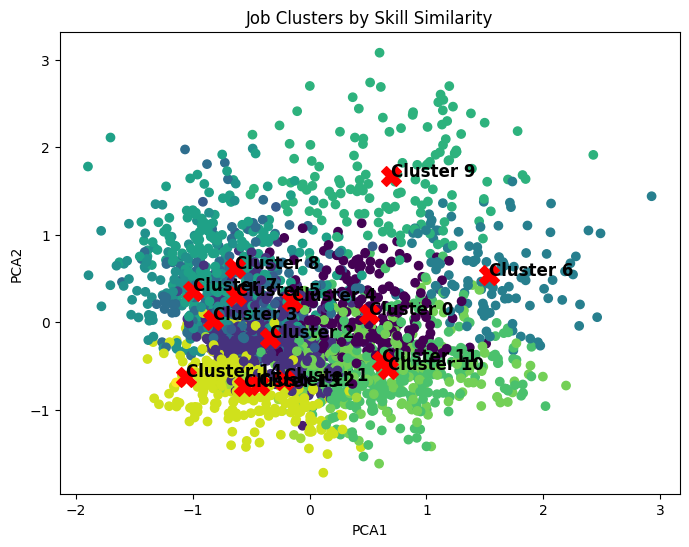

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
result_kmeans = kmeans.fit_predict(skills_df)

pca = PCA(n_components=2)
reduced = pca.fit_transform(skills_df)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=result_kmeans, cmap='viridis')

# Plot centroids
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=200, c='red', marker='X')

# Add cluster labels
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f"Cluster {i}", fontsize=12, fontweight='bold')

plt.title('Job Clusters by Skill Similarity')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [ ]:
skills_job_df['cluster_kmeans']=result_kmeans

In [ ]:
import numpy as np
import pandas as pd

skill_cols = skills_df.columns  # list of all skill names

cluster_skill_summary_kmeans = {}

for c in range(k):

    # rows belonging to this cluster
    cluster_indices = skills_job_df[skills_job_df['cluster_kmeans'] == c].index
    # print(cluster_indices)

    if len(cluster_indices) == 0:
        print(f"\n===== Cluster {c} — EMPTY CLUSTER =====")
        cluster_skill_summary_kmeans[c] = None
        continue

    # extract the rows from skills_df
    cluster_matrix = skills_df.iloc[cluster_indices]

    # convert sparse columns to dense float to avoid locked 0/1 behavior
    cluster_matrix_dense = cluster_matrix.sparse.to_dense().astype(float)

    # compute mean frequency of each skill
    skill_means = cluster_matrix_dense.mean(axis=0).sort_values(ascending=False)

    cluster_skill_summary_kmeans[c] = skill_means

    print(f"\n===== Cluster {c} — Top Skills =====")
    print(skill_means.head(10))




===== Cluster 0 — Top Skills =====
data analysis            0.893617
communication            0.425532
reporting                0.331915
business unit            0.331915
excel                    0.217021
sql                      0.208511
project management       0.187234
documentation            0.157447
compliance               0.144681
productivity software    0.140426
dtype: float64

===== Cluster 1 — Top Skills =====
electrical engineering    1.000000
systems engineering       1.000000
communication             0.833333
software development      0.666667
rf engineering            0.666667
electronics               0.666667
validation                0.666667
documentation             0.500000
embedded systems          0.500000
firmware                  0.500000
dtype: float64

===== Cluster 2 — Top Skills =====
communication           0.185417
software development    0.164583
troubleshooting         0.160417
programming             0.154167
security                0.129167
project

In [ ]:
for c in range(k):
    print(f"\n===== Cluster {c} — Top Job Roles =====")
    print(skills_job_df[skills_job_df['cluster_kmeans'] == c]['job_title'].value_counts().head(5))



===== Cluster 0 — Top Job Roles =====
job_title
Data Analyst                               17
Business Analyst                           13
Security Engineer - Threat Intelligence     6
Reliability Engineer                        5
Privacy Operations Analyst                  4
Name: count, dtype: int64

===== Cluster 1 — Top Job Roles =====
job_title
Systems Engineer                                          2
Embedded Systems Engineer                                 1
Junior Modeling and Simulation Engineer                   1
Embedded Software Engineer                                1
Electrical/ Embedded Systems Engineer (Medical Device)    1
Name: count, dtype: int64

===== Cluster 2 — Top Job Roles =====
job_title
Automation Engineer           22
Software Engineer             12
Business Analyst              11
Embedded Software Engineer     8
Technical Support Engineer     7
Name: count, dtype: int64

===== Cluster 3 — Top Job Roles =====
job_title
Test Automation Engineer (Zero 

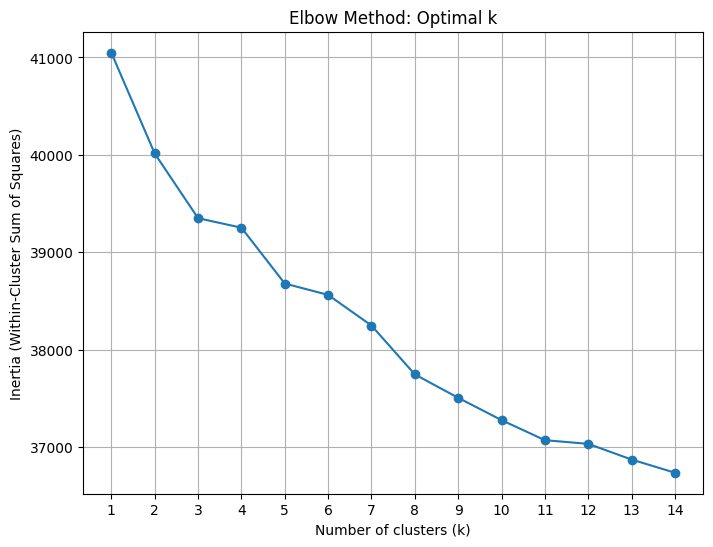

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 15)   # test k from 1 to 15

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    # from sklearn.cluster import MiniBatchKMeans

    # kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans_temp.fit(skills_df)
    inertia_values.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


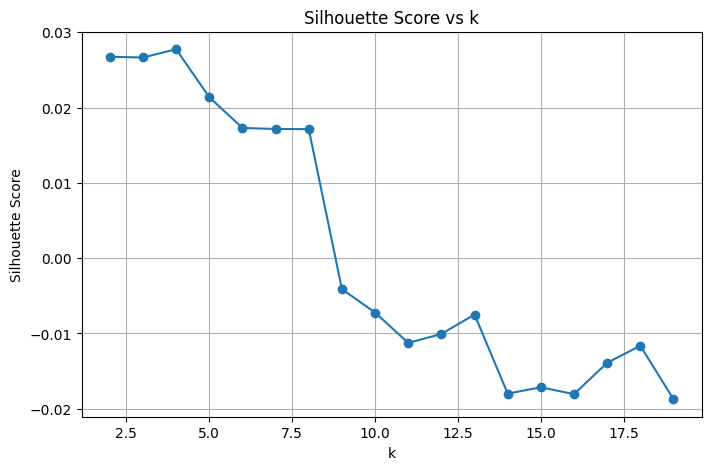

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 20)

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_temp.fit_predict(skills_df)
    score = silhouette_score(skills_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


MiniBatchKmeans

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



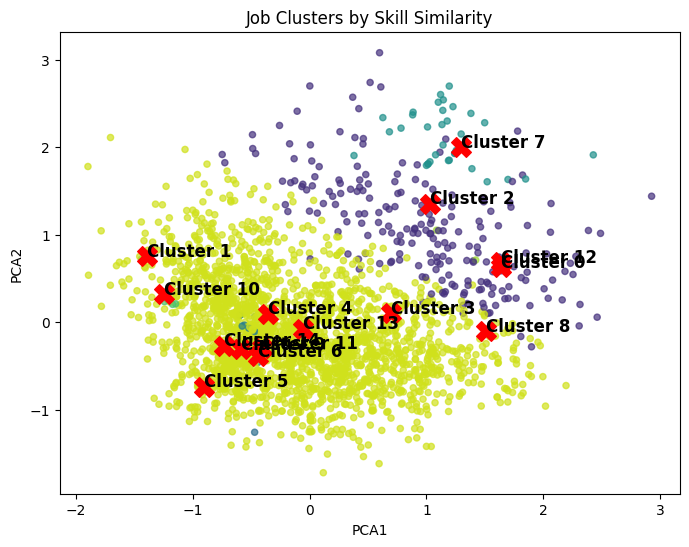

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 15
from sklearn.cluster import MiniBatchKMeans

kmeans_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
result_batch = kmeans_batch.fit_predict(skills_df)

pca = PCA(n_components=2)
reduced = pca.fit_transform(skills_df)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=result_batch, cmap='viridis', s=20, alpha=0.7)

# Plot centroids
centroids_2d = pca.transform(kmeans_batch.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
            s=200, c='red', marker='X')

# Add cluster labels
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f"Cluster {i}", fontsize=12, fontweight='bold')

plt.title('Job Clusters by Skill Similarity')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [ ]:
skills_job_df['cluster_batch_kmeans']=result_batch

In [ ]:
import numpy as np
import pandas as pd

skill_cols = skills_df.columns  # list of all skill names

cluster_skill_summary_batch_kmeans = {}

for c in range(k):

    # rows belonging to this cluster
    cluster_indices = skills_job_df[skills_job_df['cluster_batch_kmeans'] == c].index

    if len(cluster_indices) == 0:
        print(f"\n===== Cluster {c} — EMPTY CLUSTER =====")
        cluster_skill_summary_batch_kmeans[c] = None
        continue

    # extract the rows from skills_df
    cluster_matrix = skills_df.iloc[cluster_indices]

    # convert sparse columns to dense float to avoid locked 0/1 behavior
    cluster_matrix_dense = cluster_matrix.sparse.to_dense().astype(float)

    # compute mean frequency of each skill
    skill_means = cluster_matrix_dense.mean(axis=0).sort_values(ascending=False)

    cluster_skill_summary_batch_kmeans[c] = skill_means

    print(f"\n===== Cluster {c} — Top Skills =====")
    print(skill_means.head(10))




===== Cluster 0 — Top Skills =====
data communication    1.0
data collection       1.0
documentation         1.0
data warehouse        1.0
data visualization    1.0
data mining           1.0
presentation          1.0
sql                   1.0
domain knowledge      1.0
data analysis         1.0
dtype: float64

===== Cluster 1 — Top Skills =====
grafana               1.0
observability         1.0
aws                   1.0
ansible               1.0
agile                 1.0
expressjs             1.0
java                  1.0
project management    1.0
javascript            1.0
cloudwatch            1.0
dtype: float64

===== Cluster 2 — Top Skills =====
data analysis         0.882629
sql                   0.826291
data visualization    0.624413
python                0.591549
communication         0.521127
business unit         0.492958
power bi              0.446009
tableau               0.403756
data modeling         0.352113
problem solving       0.338028
dtype: float64

===== Cluster 3 

In [ ]:
for c in range(k):
    print(f"\n===== Cluster {c} — Top Job Roles =====")
    print(skills_job_df[skills_job_df['cluster_batch_kmeans'] == c]['job_title'].value_counts().head(5))



===== Cluster 0 — Top Job Roles =====
job_title
Hiring _ Business Process Data Analyst _  Des Plaines, IL    1
Name: count, dtype: int64

===== Cluster 1 — Top Job Roles =====
job_title
Consultant - Software Engineer    1
Name: count, dtype: int64

===== Cluster 2 — Top Job Roles =====
job_title
Data Analyst                                       25
Data Scientist                                     15
Future Opportunity- Data Engineering Consultant    10
Data Engineer                                       8
Business Analyst                                    6
Name: count, dtype: int64

===== Cluster 3 — Top Job Roles =====
job_title
Business Analyst    1
Name: count, dtype: int64

===== Cluster 4 — Top Job Roles =====
job_title
Salesforce Marketing Cloud Engineer    1
Name: count, dtype: int64

===== Cluster 5 — Top Job Roles =====
job_title
Security Engineer    1
Network Engineer     1
Name: count, dtype: int64

===== Cluster 6 — Top Job Roles =====
job_title
Software Engineer - Dur

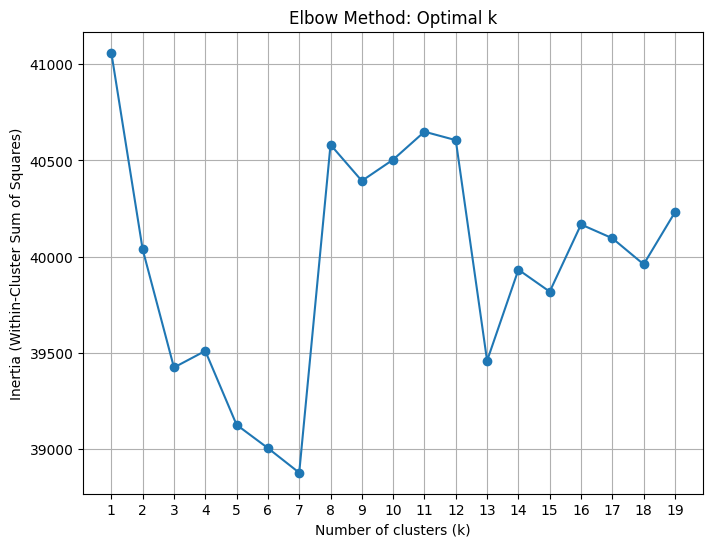

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 20)   # test k from 1 to 15

for k in k_values:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    from sklearn.cluster import MiniBatchKMeans

    kmeans_temp_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans_temp_batch.fit(skills_df)
    inertia_values.append(kmeans_temp_batch.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


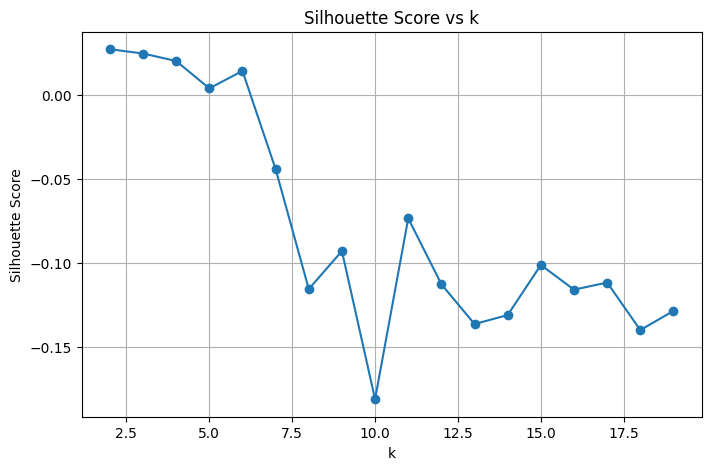

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 20)

for k in k_values:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    from sklearn.cluster import MiniBatchKMeans

    kmeans_temp_batch = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    labels = kmeans_temp_batch.fit_predict(skills_df)
    score = silhouette_score(skills_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [ ]:
# skills = [ "cybersecurity"]
skills  = [
    "Python", "R", "SQL", "Java", "C/C++", "PostgreSQL", "BigQuery", "JavaScript",
    "Jenkins", "Git", "GCP", "DevOps", "Docker", "Kubernetes", "PySpark",
    "Data Visualization", "Prometheus", "Data Integration", "AWS",
    "PyTorch", "Natural Language Processing (NLP)", "Neural Networks",
    "CNN", "RNN", "LSTM", "GRU", "FeedForward Networks", "Deep Learning",
    "Generative AI", "Recommendation System", "MLOps", "Anomaly Detection",
    "LLMs", "Graph Neural Networks", "Vertex AI", "Prompt Engineering",
    "NumPy", "Matplotlib", "Pandas", "NLTK", "Scikit-Learn", "OpenCV",
    "Grafana", "Snowflake", "Streamlit", "FastAPI", "Keras", "TensorFlow"
]
# skills = [
#     "Java", "C/C++", "Python", "FastAPI", "SQL", "PostgreSQL", "Flask", "Go",
#     "React", "JavaScript", "Typescript", "Node.js", "Kotlin",
#     "SpringBoot", "Docker", "Kubernetes", "JUnit", "Git", "AWS (S3, DynamoDB)",
#     "GCP", "ServiceNow", "Grafana", "Cassandra",
#     "Object Oriented Programming", "System Design", "Design Patterns",
#     "Microservices", "Distributed Systems", "CI/CD", "Concurrency",
#     "Mobile Application Development", "Web Application Development",
#     "Software Development Life Cycle",
#     "Reinforcement Learning", "Large Language Model (LLM)", "RAG",
#     "TensorFlow", "PyTorch", "Keras", "NumPy", "Pandas", "OpenCV",
#     "Natural Language Processing", "Graph Neural Network", "Scikit-Learn",
#     "GenAI", "Prompt Engineering", "Computer Vision"
# ]
# skills = [
#     "Python", "SQL", "NoSQL", "PL/SQL", "R", "VBA Dashboards", "Power BI",
#     "Machine Learning", "Data Analytics", "Predictive Modelling", "Visualization",
#     "Pandas", "NumPy", "TensorFlow", "Scikit-Learn", "Matplotlib", "Seaborn",
#     "Snowflake", "MongoDB", "Neo4j"
# ]
# user_skills = [s.lower() for s in skills]
# First skill set
anshika = "Python, R, SQL, Java, C/C++, PostgreSQL, BigQuery, JavaScript, Jenkins, Git, GCP, DevOps, Docker, Kubernetes, PySpark, Data Visualization, Prometheus, Data Integration, AWS, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Recommendation System, MLOps, Anomaly Detection, LLMs, Graph Neural Networks, Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"
anshika = "Python, SQL, C/C++, PostgreSQL, BigQuery,  Jenkins, Git, GCP,  PySpark, Data Visualization, Prometheus, Data Integration, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Anomaly Detection, LLMs,  Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"

# Second skill set
mayank = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, Flask, Go, React, JavaScript, Typescript, Node.js, Kotlin, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), GCP, ServiceNow, Grafana, Cassandra, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Mobile Application Development, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, Keras, NumPy, Pandas, OpenCV, Natural Language Processing, Graph Neural Network, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"
mayank = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, React, JavaScript, Node.js, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), ServiceNow, Grafana, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, NumPy, Pandas, Natural Language Processing, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"

# Third skill set
friend = "Python, SQL, NoSQL, PL/SQL, R, VBA Dashboards, Power BI, Machine Learning, Data Analytics, Predictive Modelling, Visualization, Pandas, NumPy, TensorFlow, Scikit-Learn, Matplotlib, Seaborn, Snowflake, MongoDB, Neo4j"
temp = "R, SQL, Java, Python, Shell/Bash Scripting, PowerShell automation, SIEM: Elastic Stack, SIEM: Microsoft Defender XDR, EDR/XDR: SentinelOne, EDR/XDR: CrowdStrike, IDS/IPS deployment and monitoring, Vulnerability Management, Nessus, OpenVAS, Qualys, Web App Security: OWASP ZAP, Web App Security: Burp Suite, Penetration Testing: Metasploit, Penetration Testing: Nmap, AWS, Azure AD security, Firewalls, VPNs, Wireshark, Network Traffic Analysis: tcpdump, Network Traffic Analysis: Snort"
skills=anshika
user_skills=split_normalize_and_canonicalize(skills)

def encode_user_skills(user_skills, all_skills):
    vec = np.zeros(len(all_skills))
    for skill in user_skills:
        if skill in all_skills:
            print(skill)
            vec[all_skills.index(skill)] = 1
    return vec

all_skills = skills_df.columns.tolist()
user_vector = encode_user_skills(user_skills, all_skills).reshape(1, -1)


business intelligence
c++
computer vision
data integration
data visualization
deep learning
fastapi
gcp
generative ai
git
grafana
jenkins
keras
machine learning
neural networks
nlp
numpy
pandas
postgresql
prometheus
pyspark
python
pytorch
snowflake
sql
tensorflow


In [ ]:
skill_cols = skills_df.columns.tolist()

user_vector = pd.Series(0, index=skill_cols)
for skill in user_skills:
    if skill in user_vector.index:
        print(skill)
        user_vector[skill] = 1


business intelligence
c++
computer vision
data integration
data visualization
deep learning
fastapi
gcp
generative ai
git
grafana
jenkins
keras
machine learning
neural networks
nlp
numpy
pandas
postgresql
prometheus
pyspark
python
pytorch
snowflake
sql
tensorflow


In [ ]:
user_vector.sort_values(ascending=False).head(20)

,0
machine learning,1
keras,1
prometheus,1
data visualization,1
numpy,1
sql,1
gcp,1
deep learning,1
business intelligence,1
c++,1


batch is better

In [ ]:
algo_col_name="cluster_kmeans"
cluster_skill_summary=cluster_skill_summary_kmeans

result is incorrect, need to debug, check cluster 0th indexing and 1,

In [ ]:
skills_job_df[algo_col_name].unique()

array([10, 13, 11,  2,  0,  9,  7,  6,  5,  8,  1,  4, 12,  3, 14],
      dtype=int32)

In [ ]:
cluster_centroids = {}

for c in range(k):
    idx = skills_job_df[skills_job_df[algo_col_name] == c].index

    if len(idx) == 0:
        continue

    # Convert sparse to dense before mean
    centroid = (
        skills_df.iloc[idx]
        .sparse.to_dense()
        .astype(float)
        .mean(axis=0)
        .values   # ✅ convert to NumPy array
    )

    cluster_centroids[c] = centroid


In [ ]:
user_vec = user_vector.values.astype(float).reshape(1, -1)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = {}

for c, centroid in cluster_centroids.items():
    centroid_vec = centroid.reshape(1, -1)   # ✅ NOW this works
    sim = cosine_similarity(user_vec, centroid_vec)[0][0]
    similarities[c] = sim

best_cluster = max(similarities, key=similarities.get)

print("✅ Correct Closest Cluster by Similarity:", best_cluster)
print("✅ All Similarities:", similarities)


✅ Correct Closest Cluster by Similarity: 9
✅ All Similarities: {0: np.float64(0.09109927466864287), 1: np.float64(0.04305308489096177), 2: np.float64(0.13116835948723096), 3: np.float64(0.03081667756806829), 4: np.float64(0.09091260923674509), 5: np.float64(0.286599145443789), 6: np.float64(0.16094999037229626), 7: np.float64(0.1734331319159541), 8: np.float64(0.18931609597880217), 9: np.float64(0.3234423117727435), 10: np.float64(0.049153958319139865), 11: np.float64(0.02972485295019384), 12: np.float64(0.028034475568745346), 13: np.float64(0.020744402259086817), 14: np.float64(0.0)}


In [ ]:
def recommend_missing_skills_from_cluster(user_vector, cluster_skill_summary, cluster_id, top_n=5):

    skill_means = cluster_skill_summary[cluster_id]

    if skill_means is None:
        print("⚠️ Empty cluster — no recommendations available.")
        return None

    # Mask skills the user already has
    missing_skills = skill_means[user_vector == 0]

    return missing_skills.head(top_n)

recommended_skills = recommend_missing_skills_from_cluster(
    user_vector=user_vector,
    cluster_skill_summary=cluster_skill_summary, #update this
    cluster_id=best_cluster,
    top_n=5
)

print("\n✅ Recommended Missing Skills:")
print(recommended_skills)



✅ Recommended Missing Skills:
data analysis    0.883212
data science     0.576642
r                0.569343
tableau          0.518248
data mining      0.489051
dtype: float64


In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Job vectors (dense)
job_matrix_dense = skills_df.sparse.to_dense().astype(float).values

# Centroids + user
centroid_matrix = np.vstack(list(cluster_centroids.values()))
vectors_for_pca = np.vstack([job_matrix_dense, centroid_matrix, user_vec])  # JOB first, then CENTROID, then USER

# Labels for hover
labels = skills_job_df["job_title"].tolist() + [f"Cluster {c}" for c in cluster_centroids.keys()] + ["USER"]

# Role type for coloring
types = ["JOB"] * job_matrix_dense.shape[0] + ["CENTROID"] * len(cluster_centroids) + ["USER"]


In [ ]:
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors_for_pca)

df_plot = pd.DataFrame({
    "x": vectors_2d[:, 0],
    "y": vectors_2d[:, 1],
    "label": labels,
    "type": types
})


In [ ]:
fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    color="type",
    symbol="type",
    hover_name="label",
    size=[6 if t=="JOB" else 12 if t=="CENTROID" else 15 for t in df_plot["type"]],
    color_discrete_map={"USER":"red","CENTROID":"blue","JOB":"lightgray"}
)

fig.update_layout(
    title="User Skill Vector vs Job Clusters (Interactive PCA)",
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Point Type",
    width=900,
    height=700
)

fig.show()


can suggest roles using above (print that)
# MACHINE LEARNING ROLE PREDICTION


In [ ]:
skills_job_df.head()

,job_title,.net,.net development,.net maui,2 years’ experience as an operations analyst,23 years’ experience,3d modeling,5 10+ years’ experience,5+ years’ experience as business systems engineer,ab initio,...,x86 architecture,xaml,xml,xp,xray imaging,yaml,zabbix,zero trust,cluster_kmeans,cluster_batch_kmeans
0,RF Systems Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
1,Security Engineer Associate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
2,Cyber Security Analyst,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,"Business Analyst 4 - Lansing, MI - 12+ Months ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,1
4,Systems Administrator,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0


In [ ]:
import pandas as pd

# Role mapping dictionary
role_mapping = {
    'Software Engineer': ['software engineer', 'software developer', 'application developer'],
    'Backend Engineer': ['backend engineer', 'backend developer', 'backend software engineer', 'server-side engineer'],
    'Frontend Engineer': ['frontend engineer', 'frontend developer', 'web frontend developer', 'ui engineer'],
    'Full Stack Engineer': ['full-stack engineer', 'full-stack developer', 'full stack developer'],
    'Mobile Engineer': ['mobile engineer', 'mobile developer', 'mobile app developer', 'app developer', 'ios developer', 'android developer'],
    'DevOps Engineer': ['devops', 'devops engineer', 'devops developer', 'devops specialist', 'devops consultant'],
    'Site Reliability Engineer': ['sre', 'site reliability engineer', 'reliability engineer', 'cloud sre'],
    'Cloud Engineer': ['cloud engineer', 'cloud developer', 'cloud platform engineer', 'cloud solutions engineer', 'cloud infrastructure engineer', 'cloud systems engineer', 'cloud infrastructure architect', 'cloud system architect', 'cloud solutions architect', 'cloud architect'],
    'Data Engineer': ['data engineer', 'big data engineer'],
    'Data Scientist': ['data scientist', 'data analyst', 'business analyst', 'business intelligence analyst'],
    'ML Engineer': ['ml engineer', 'machine learning engineer', 'ml developer', 'mlops engineer'],
    'ML Researcher': ['ml researcher', 'ml research engineer', 'research scientist ml', 'ai researcher'],
    'AI Engineer': ['ai engineer', 'artificial intelligence engineer', 'applied ai engineer', 'applied scientist'],
    'Computer Vision Engineer': ['computer vision engineer', 'cv engineer', 'computer vision developer', 'image processing engineer'],
    'NLP Engineer': ['nlp engineer'],
    'Deep Learning Engineer': ['deep learning engineer'],
    'Research Scientist': ['research scientist'],
    'Data Product Manager': ['data product manager'],
    'Platform Engineer': ['platform engineer', 'platform developer', 'platform operations engineer'],
    'Infrastructure Engineer': ['infrastructure engineer', 'it infrastructure engineer'],
    'Systems Engineer': ['systems engineer', 'systems administrator'],
    'Embedded Software Engineer': ['embedded software engineer', 'embedded robotics engineer'],
    'Robotics Engineer': ['robotics engineer', 'robotics software engineer', 'autonomous systems engineer'],
    'Security Engineer': ['security engineer', 'cybersecurity engineer', 'cybersecurity analyst', 'information security engineer', 'it security engineer', 'security analyst'],
    'Network Engineer': ['network engineer'],
    'Game Developer': ['game developer', 'game software engineer', 'game programmer', 'unity developer', 'unreal engine developer'],
    'Simulation Engineer': ['simulation engineer', 'simulation software engineer', 'simulation developer', 'modeling engineer'],
    'AR/VR Engineer': ['ar/vr engineer'],
    'Blockchain Engineer': ['blockchain engineer'],
    'API Developer': ['api developer'],
    'React Developer': ['react developer'],
    'Angular Developer': ['angular developer'],
    'Product Manager': ['product manager'],
    'Technical Program Manager': ['technical program manager'],
    'Quantitative Analyst': ['quantitative analyst', 'operations analyst'],
    'IT Support Engineer': ['it support engineer', 'it support specialist', 'technical support engineer', 'desktop support engineer', 'it helpdesk'],
    'Automation Engineer': ['automation engineer']
}

# Create reverse mapping for quick lookup
title_to_consolidated = {}
for consolidated_role, variants in role_mapping.items():
    for variant in variants:
        title_to_consolidated[variant] = consolidated_role

# Map job titles to consolidated roles
skills_job_df['class_label'] = skills_job_df['job_title'].str.lower().map(title_to_consolidated)

# Remove rows that couldn't be mapped
skills_job_df_mapped = skills_job_df.dropna(subset=['class_label']).copy()

# Get skill columns (all columns except job_title and consolidated_role)
skill_columns = [col for col in skills_job_df_mapped.columns if col not in ['job_title', 'class_label']]

# Reorder columns: consolidated_role first, then skills
final_df = skills_job_df_mapped[['class_label'] + skill_columns].copy()

# Print summary
print(f"Total rows mapped: {len(final_df)}")
print(f"Total unique consolidated roles: {final_df['class_label'].nunique()}")
print(f"\nRole distribution:")
print(final_df['class_label'].value_counts())

Total rows mapped: 686
Total unique consolidated roles: 28

Role distribution:
class_label
Data Scientist                203
Software Engineer             106
Network Engineer               56
Systems Engineer               46
Automation Engineer            30
Data Engineer                  27
IT Support Engineer            26
Site Reliability Engineer      22
Security Engineer              21
DevOps Engineer                21
Embedded Software Engineer     20
Full Stack Engineer            16
Quantitative Analyst           13
ML Engineer                    13
Research Scientist             10
Mobile Engineer                10
Frontend Engineer               9
Cloud Engineer                  9
Infrastructure Engineer         6
Angular Developer               5
Robotics Engineer               5
AI Engineer                     2
React Developer                 2
Platform Engineer               2
Computer Vision Engineer        2
Backend Engineer                2
Simulation Engineer      

In [ ]:
skills_job_df[skills_job_df['job_title']=='Experienced Associate, Software Engineer (Python/SQL)']

,job_title,.net,.net (c#),.net development,.net maui,3+ years of technical sales,3+ years technical sales experience,3d modeling,5 why,5why,...,xcuitests,xml,xp,xray imaging,yaml,zabbix,zero trust,cluster_kmeans,cluster_batch_kmeans,consolidated_role


In [ ]:
title_to_class = {title: idx for idx, title in enumerate(tech_title_anchors)}
class_to_title = {v: k for k, v in title_to_class.items()}
def map_title_to_class(title):
    for anchor in tech_title_anchors:
        if anchor in title.lower():
            return title_to_class[anchor]
    return None

skills_job_df['class_label'] = skills_job_df['job_title'].str.lower().apply(map_title_to_class)


In [ ]:
class_to_title

{0: 'software engineer',
 1: 'software developer',
 2: 'backend engineer',
 3: 'frontend engineer',
 4: 'full-stack engineer',
 5: 'systems engineer',
 6: 'platform engineer',
 7: 'site reliability engineer',
 8: 'devops engineer',
 9: 'cloud engineer',
 10: 'infrastructure engineer',
 11: 'application developer',
 12: 'embedded software engineer',
 13: 'mobile engineer',
 14: 'data scientist',
 15: 'data analyst',
 16: 'machine learning engineer',
 17: 'ai engineer',
 18: 'applied scientist',
 19: 'research scientist',
 20: 'data engineer',
 21: 'ml research engineer',
 22: 'deep learning engineer',
 23: 'nlp engineer',
 24: 'computer vision engineer',
 25: 'mlops engineer',
 26: 'cybersecurity engineer',
 27: 'security analyst',
 28: 'security engineer',
 29: 'information security engineer',
 30: 'network engineer',
 31: 'it support engineer',
 32: 'systems administrator',
 33: 'product manager',
 34: 'technical program manager',
 35: 'business analyst',
 36: 'quantitative analyst',


In [ ]:
final_df.columns

Index(['class_label', '.net', '.net (c#)', '.net development', '.net maui',
       '3+ years of technical sales', '3+ years technical sales experience',
       '3d modeling', '5 why', '5why',
       ...
       'xaml', 'xcuitests', 'xml', 'xp', 'xray imaging', 'yaml', 'zabbix',
       'zero trust', 'cluster_kmeans', 'cluster_batch_kmeans'],
      dtype='object', length=2560)

In [ ]:
skills_job_df=final_df

skills_job_df.dropna()

,class_label,.net,.net (c#),.net development,.net maui,3+ years of technical sales,3+ years technical sales experience,3d modeling,5 why,5why,...,xaml,xcuitests,xml,xp,xray imaging,yaml,zabbix,zero trust,cluster_kmeans,cluster_batch_kmeans
4,Systems Engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,13
5,Research Scientist,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,13
6,Research Scientist,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,13
9,Data Scientist,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,2
21,Data Scientist,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,Automation Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,13
2414,Network Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,13
2416,Data Scientist,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,13
2417,Embedded Software Engineer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,13


In [ ]:
cls_counts = skills_job_df['class_label'].value_counts()
valid_classes = cls_counts[cls_counts > 1].index

skills_job_df = skills_job_df[skills_job_df['class_label'].isin(valid_classes)]


# Map index to title and print
for cls, count in cls_counts.items():
    title = class_to_title.get(cls, f"Unknown({cls})")
    print(f"{title}: {count}")


Unknown(Data Scientist): 203
Unknown(Software Engineer): 106
Unknown(Network Engineer): 56
Unknown(Systems Engineer): 46
Unknown(Automation Engineer): 30
Unknown(Data Engineer): 27
Unknown(IT Support Engineer): 26
Unknown(Site Reliability Engineer): 22
Unknown(Security Engineer): 21
Unknown(DevOps Engineer): 21
Unknown(Embedded Software Engineer): 20
Unknown(Full Stack Engineer): 16
Unknown(Quantitative Analyst): 13
Unknown(ML Engineer): 13
Unknown(Research Scientist): 10
Unknown(Mobile Engineer): 10
Unknown(Frontend Engineer): 9
Unknown(Cloud Engineer): 9
Unknown(Infrastructure Engineer): 6
Unknown(Angular Developer): 5
Unknown(Robotics Engineer): 5
Unknown(AI Engineer): 2
Unknown(React Developer): 2
Unknown(Platform Engineer): 2
Unknown(Computer Vision Engineer): 2
Unknown(Backend Engineer): 2
Unknown(Simulation Engineer): 1
Unknown(Game Developer): 1


In [ ]:
skill_cols = [c for c in skills_job_df.columns if c not in ['job_title', 'class_label','irrelevant_skill', 'irrelevant_skills','cluster_batch_kmeans',
 'cluster_kmeans','class_label']]
X = skills_job_df[skill_cols].values
y = skills_job_df['class_label'].values


In [ ]:
X.shape

(684, 2555)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced_subsample",
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print(classification_report(y_test, preds))


                            precision    recall  f1-score   support

         Angular Developer       0.00      0.00      0.00         1
       Automation Engineer       0.83      0.83      0.83         6
            Cloud Engineer       0.00      0.00      0.00         2
  Computer Vision Engineer       0.00      0.00      0.00         1
             Data Engineer       1.00      0.33      0.50         6
            Data Scientist       0.66      0.98      0.78        41
           DevOps Engineer       0.60      0.75      0.67         4
Embedded Software Engineer       0.75      0.75      0.75         4
         Frontend Engineer       1.00      0.50      0.67         2
       Full Stack Engineer       0.00      0.00      0.00         3
       IT Support Engineer       0.50      0.40      0.44         5
   Infrastructure Engineer       0.00      0.00      0.00         1
               ML Engineer       0.75      1.00      0.86         3
           Mobile Engineer       0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
X_test.shape

(137, 2555)

In [ ]:
# skills = [ "cybersecurity"]
skills  = [
    "Python", "R", "SQL", "Java", "C/C++", "PostgreSQL", "BigQuery", "JavaScript",
    "Jenkins", "Git", "GCP", "DevOps", "Docker", "Kubernetes", "PySpark",
    "Data Visualization", "Prometheus", "Data Integration", "AWS",
    "PyTorch", "Natural Language Processing (NLP)", "Neural Networks",
    "CNN", "RNN", "LSTM", "GRU", "FeedForward Networks", "Deep Learning",
    "Generative AI", "Recommendation System", "MLOps", "Anomaly Detection",
    "LLMs", "Graph Neural Networks", "Vertex AI", "Prompt Engineering",
    "NumPy", "Matplotlib", "Pandas", "NLTK", "Scikit-Learn", "OpenCV",
    "Grafana", "Snowflake", "Streamlit", "FastAPI", "Keras", "TensorFlow"
]
# skills = [
#     "Java", "C/C++", "Python", "FastAPI", "SQL", "PostgreSQL", "Flask", "Go",
#     "React", "JavaScript", "Typescript", "Node.js", "Kotlin",
#     "SpringBoot", "Docker", "Kubernetes", "JUnit", "Git", "AWS (S3, DynamoDB)",
#     "GCP", "ServiceNow", "Grafana", "Cassandra",
#     "Object Oriented Programming", "System Design", "Design Patterns",
#     "Microservices", "Distributed Systems", "CI/CD", "Concurrency",
#     "Mobile Application Development", "Web Application Development",
#     "Software Development Life Cycle",
#     "Reinforcement Learning", "Large Language Model (LLM)", "RAG",
#     "TensorFlow", "PyTorch", "Keras", "NumPy", "Pandas", "OpenCV",
#     "Natural Language Processing", "Graph Neural Network", "Scikit-Learn",
#     "GenAI", "Prompt Engineering", "Computer Vision"
# ]
# skills = [
#     "Python", "SQL", "NoSQL", "PL/SQL", "R", "VBA Dashboards", "Power BI",
#     "Machine Learning", "Data Analytics", "Predictive Modelling", "Visualization",
#     "Pandas", "NumPy", "TensorFlow", "Scikit-Learn", "Matplotlib", "Seaborn",
#     "Snowflake", "MongoDB", "Neo4j"
# ]
# user_skills = [s.lower() for s in skills]
# First skill set
anshika1 = "Python, R, SQL, Java, C/C++, PostgreSQL, BigQuery, JavaScript, Jenkins, Git, GCP, DevOps, Docker, Kubernetes, PySpark, Data Visualization, Prometheus, Data Integration, AWS, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Recommendation System, MLOps, Anomaly Detection, LLMs, Graph Neural Networks, Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"
anshika = "Python, SQL, C/C++, PostgreSQL, BigQuery,  Jenkins, Git, GCP,  PySpark, Data Visualization, Prometheus, Data Integration, PyTorch, Natural Language Processing (NLP), Neural Networks, CNN, RNN, LSTM, GRU, FeedForward Networks, Deep Learning, Generative AI, Anomaly Detection, LLMs,  Vertex AI, Prompt Engineering, NumPy, Matplotlib, Pandas, NLTK, Scikit-Learn, OpenCV, Grafana, Snowflake, Streamlit, FastAPI, Keras, TensorFlow"

# Second skill set
mayank1 = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, Flask, Go, React, JavaScript, Typescript, Node.js, Kotlin, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), GCP, ServiceNow, Grafana, Cassandra, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Mobile Application Development, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, Keras, NumPy, Pandas, OpenCV, Natural Language Processing, Graph Neural Network, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"
mayank = "Java, C/C++, Python, FastAPI, SQL, PostgreSQL, React, JavaScript, Node.js, SpringBoot, Docker, Kubernetes, JUnit, Git, AWS (S3, DynamoDB), ServiceNow, Grafana, Object Oriented Programming, System Design, Design Patterns, Microservices, Distributed Systems, CI/CD, Concurrency, Web Application Development, Software Development Life Cycle, Reinforcement Learning, Large Language Model (LLM), RAG, TensorFlow, PyTorch, NumPy, Pandas, Natural Language Processing, Scikit-Learn, GenAI, Prompt Engineering, Computer Vision"

# Third skill set
friend = "Python, SQL, NoSQL, PL/SQL, R, VBA Dashboards, Power BI, Machine Learning, Data Analytics, Predictive Modelling, Visualization, Pandas, NumPy, TensorFlow, Scikit-Learn, Matplotlib, Seaborn, Snowflake, MongoDB, Neo4j"

skills=mayank
user_skills=split_normalize_and_canonicalize(skills)

def encode_user_skills(user_skills, all_skills):
    vec = np.zeros(len(all_skills))
    for skill in user_skills:
        if skill in all_skills:
            print(skill)
            vec[all_skills.index(skill)] = 1
    return vec

all_skills = skills_df.columns.tolist()
user_vector = encode_user_skills(user_skills, all_skills).reshape(1, -1)


c++
ci/cd
computer vision
design patterns
distributed systems
docker
fastapi
git
grafana
java
javascript
junit
kubernetes
machine learning
microservices
nlp
node.js
numpy
oop
pandas
parallel programming
postgresql
python
pytorch
react
reinforcement learning
sdlc
servicenow
spring boot
sql
systems engineering
tensorflow
web development


In [ ]:
user_vector

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def predict_user_role(user_vector, model=rf):
    # convert to numpy array for safety
    user_vector = np.array(user_vector).reshape(1, -1)

    # predict class
    pred_class = model.predict(user_vector)[0]
    print(pred_class)
    # map back to job title
    return class_to_title[pred_class]


In [ ]:

predicted_role = predict_user_role(user_vector)
print("Your predicted role:", predicted_role)

Software Engineer


KeyError: 'Software Engineer'

In [ ]:
s1=skills_df.columns
s2=skills_job_df.columns
set(s2)-set(s1)

{'class_label',
 'cluster_batch_kmeans',
 'cluster_kmeans',
 'irrelevant_skill',
 'irrelevant_skills'}

In [ ]:
def top_k_roles(user_vector, k=3, model=rf):
    user_vector = np.array(user_vector).reshape(1, -1)
    probs = model.predict_proba(user_vector)[0]

    top_idx = probs.argsort()[::-1][:k]
    top_roles = [(class_to_title[i], probs[i]) for i in top_idx]

    return top_roles


In [ ]:
top_k_roles(user_vector, k=3)


[('platform developer', np.float64(0.2966666666666667)),
 ('reliability engineer', np.float64(0.16666666666666666)),
 ('quantitative analyst', np.float64(0.16))]

In [ ]:
temp="Gameplay Programming, Virtual Reality (VR), 3D Modeling, Blender, Unity Development, Game Development, Technical Project Leadership, Data Analysis, Machine Learning, Data Science, Statistics, Data Analytics, Natural Language Processing (NLP), Computer Science, MySQL, Microsoft Office, Tableau, Microsoft Excel, Git, TensorFlow, Microsoft Power BI, Data Cleaning, Exploratory Data Analysis, Database Management System (DBMS), Data Processing, Data Visualization, Python (Programming Language), R (Programming Language), SQL, C#, Virtual Reality Development, Unity, React.js, JavaScript, Cascading Style Sheets (CSS), Tailwind CSS, HTML5, Java, C (Programming Language), C++, Figma (Software), Web Development"
temp="R, SQL, Java, Python, Shell/Bash Scripting, PowerShell automation, SIEM: Elastic Stack, SIEM: Microsoft Defender XDR, EDR/XDR: SentinelOne, EDR/XDR: CrowdStrike, IDS/IPS deployment and monitoring, Vulnerability Management, Nessus, OpenVAS, Qualys, Web App Security: OWASP ZAP, Web App Security: Burp Suite, Penetration Testing: Metasploit, Penetration Testing: Nmap, AWS, Azure AD security, Firewalls, VPNs, Wireshark, Network Traffic Analysis: tcpdump, Network Traffic Analysis: Snort"

In [ ]:
skills=temp
k=3
user_skills=split_normalize_and_canonicalize(skills)
all_skills = skills_df.columns.tolist()
user_vector = encode_user_skills(user_skills, all_skills).reshape(1, -1)
# predicted_role = predict_user_role(user_vector)
print("PREDICTED ROLE:", predicted_role)
print(f"TOP {k} roles",top_k_roles(user_vector, k))

aws
firewalls
java
network analysis
python
r
sql
vpn
vulnerability management
vulnerability scanner
PREDICTED ROLE: software engineer
TOP 3 roles [('quantitative analyst', np.float64(0.34)), ('platform developer', np.float64(0.21333333333333335)), ('cloud system architect', np.float64(0.21))]


HELPER FUNCTIONS for calculating the mapping
strings=list(df_tech_bin_filtered.columns)[:]
from collections import Counter

first_words = [s.split()[0] for s in strings]
counts = Counter(first_words)

print(counts)


prefix = "project"
map_value = "project management"

matches = [s for s in strings if s.startswith(prefix)]

print(f"Strings starting with '{prefix}':")
for m in matches:
    print(" -", m)

mapping = {s: map_value for s in matches if s.startswith(prefix)}

mapping
# Mapping dictionary
data_mapping1 = {
  "project": "project management",
  "it": "it"

}

data_mapping=ADDITIONAL_SKILLS3
# Generate mapping for strings that start with any key in data_mapping
mapped_strings = {}

for s in strings:
    for key, value in data_mapping.items():
        if s.lower().startswith(key.lower()):  # case-insensitive match
            mapped_strings[s] = value
            # break  # stop after first match

# Output
# mapped_strings
with open("new_mappings4.json", "w") as f:
    json.dump(mapped_strings, f, indent=4)

print("Dictionary saved as data_mapping.json")
import pandas as pd
import json

# Your dictionary
skill_mappings = NEW_MAPPINGS
file_name = "new_mappings3.json"

# Create DataFrame with all operations
df_final = (pd.DataFrame(list(skill_mappings.items()), columns=['skill', 'mapping'])
            .drop_duplicates()
            .sort_values(by='skill')
            .reset_index(drop=True))

print("Final DataFrame:")
print(df_final)

# Convert to dictionary format {skill: mapping}
skill_mapping_dict = df_final.set_index('skill')['mapping'].to_dict()

# Save to JSON
with open(file_name, 'w') as f:
    json.dump(skill_mapping_dict, f, indent=2)

print(f'\n✓ JSON file saved as {file_name}')

# # Display the JSON content
# with open(file_name, 'r') as f:
#     print("\nJSON Content:")
#     print(f.read())


In [ ]:
strings=list(df_tech_bin_filtered.columns)[:]
from collections import Counter

first_words = [s.split()[0] for s in strings]
counts = Counter(first_words)

print(counts)



Counter({'data': 349, 'project': 94, 'cloud': 81, 'software': 65, 'security': 63, 'process': 60, 'product': 59, 'enterprise': 58, 'customer': 57, 'database': 50, 'computer': 36, 'it': 35, 'business': 34, 'complex': 33, 'network': 32, 'systems': 31, 'engineering': 30, 'finance': 30, 'power': 30, 'financial': 28, 'electrical': 26, 'communication': 25, 'healthcare': 25, 'programming': 25, 'public': 25, 'soft': 24, 'compliance': 23, 'embedded': 23, 'hardware': 22, 'professional': 22, 'program': 22, 'aws': 21, 'information': 21, 'web': 21, 'change': 20, 'continuous': 20, 'documentation': 19, 'erp': 19, 'networking': 19, 'configuration': 18, 'quantitative': 18, 'code': 17, 'crm': 17, 'electronic': 17, 'microsoft': 17, 'proficiency': 17, 'sales': 17, 'certified': 16, 'collaboration': 16, 'cost': 16, 'distributed': 16, 'system': 16, 'company': 15, 'equipment': 15, 'risk': 15, 'cloudbased': 14, 'crossfunctional': 14, 'cyber': 14, 'problem': 14, 'technical': 14, 'container': 13, 'epic': 13, 'gov

In [ ]:
prefix = "project"
map_value = "project management"

matches = [s for s in strings if s.startswith(prefix)]

print(f"Strings starting with '{prefix}':")
for m in matches:
    print(" -", m)

mapping = {s: map_value for s in matches if s.startswith(prefix)}

mapping

Strings starting with 'project':
 - project activities
 - project administration
 - project analysis
 - project and process tasks/flows
 - project artifacts
 - project audits
 - project automation
 - project budget
 - project budget and schedule management
 - project budget definition
 - project charters
 - project closure
 - project controls
 - project costing
 - project discovery
 - project documents
 - project engagement for finance system improvement
 - project engineering
 - project estimating
 - project evaluation
 - project expenditure monitoring
 - project formulation and planning
 - project framework
 - project governance
 - project handoff
 - project handoff and closure
 - project health monitoring
 - project information management
 - project justification
 - project lead
 - project leading
 - project life cycle
 - project life cycle process
 - project lifecycle
 - project management concepts
 - project management fundamentals
 - project management institute project managemen

{'project activities': 'project management',
 'project administration': 'project management',
 'project analysis': 'project management',
 'project and process tasks/flows': 'project management',
 'project artifacts': 'project management',
 'project audits': 'project management',
 'project automation': 'project management',
 'project budget': 'project management',
 'project budget and schedule management': 'project management',
 'project budget definition': 'project management',
 'project charters': 'project management',
 'project closure': 'project management',
 'project controls': 'project management',
 'project costing': 'project management',
 'project discovery': 'project management',
 'project documents': 'project management',
 'project engagement for finance system improvement': 'project management',
 'project engineering': 'project management',
 'project estimating': 'project management',
 'project evaluation': 'project management',
 'project expenditure monitoring': 'project man

In [ ]:
# Mapping dictionary
data_mapping1 = {
  "project": "project management",
  "it": "it"

}

data_mapping=ADDITIONAL_SKILLS3
# Generate mapping for strings that start with any key in data_mapping
mapped_strings = {}

for s in strings:
    for key, value in data_mapping.items():
        if s.lower().startswith(key.lower()):  # case-insensitive match
            mapped_strings[s] = value
            # break  # stop after first match

# Output
# mapped_strings
with open("new_mappings4.json", "w") as f:
    json.dump(mapped_strings, f, indent=4)

print("Dictionary saved as data_mapping.json")

Dictionary saved as data_mapping.json


In [ ]:
import pandas as pd
import json

# Your dictionary
skill_mappings = NEW_MAPPINGS
file_name = "new_mappings3.json"

# Create DataFrame with all operations
df_final = (pd.DataFrame(list(skill_mappings.items()), columns=['skill', 'mapping'])
            .drop_duplicates()
            .sort_values(by='skill')
            .reset_index(drop=True))

print("Final DataFrame:")
print(df_final)

# Convert to dictionary format {skill: mapping}
skill_mapping_dict = df_final.set_index('skill')['mapping'].to_dict()

# Save to JSON
with open(file_name, 'w') as f:
    json.dump(skill_mapping_dict, f, indent=2)

print(f'\n✓ JSON file saved as {file_name}')

# # Display the JSON content
# with open(file_name, 'r') as f:
#     print("\nJSON Content:")
#     print(f.read())

Final DataFrame:
                                                  skill  \
0          2 years' experience as an operations analyst   
1                                  23 years' experience   
2                              5  10+ years' experience   
3     5+ years' experience as business systems engineer   
4                                              abinitio   
...                                                 ...   
4019                                          zerotrust   
4020                                             zigbee   
4021                                          zookeeper   
4022                                               zoom   
4023                                            zscaler   

                           mapping  
0              operations analysis  
1                 irrelevant_skill  
2                 irrelevant_skill  
3     business systems engineering  
4                        ab initio  
...                            ...  
4019           

In [ ]:
with open("new_mapping4.json", "r") as f:
    json1 = json.load(f)

with open("incorrect_ones.json", "r") as f:
    json2 = json.load(f)

In [ ]:
import json

# Your original dictionaries
# json1 = {"a": 1, "b": 2, "c": 3, "d": 4}
# json2 = {"b": 5, "d": 6}

# Remove keys from json1 that exist in json2
filtered_json1 = {key: value for key, value in json1.items() if key not in json2}

# Combine filtered_json1 and json2
json3 = {**filtered_json1, **json2}

print(json3)  # Output: {'a': 1, 'c': 3, 'b': 5, 'd': 6}

# Save to a file
with open('new_mapping4_fixed.json', 'w') as f:
    json.dump(json3, f, indent=4)

print("Saved to new_mapping4_fixed.json")

{'accessibility': 'access control', 'accreditation': 'compliance', 'actuarial science': 'actuarial science', 'agriculture': 'agriculture', 'analytics degree': 'data analysis', 'application development': 'software development', 'ar': 'ar', 'architecture': 'ar', 'artifact repository': 'ar', 'artifactory': 'ar', 'aruba networks': 'ar', 'audio engineering': 'audio engineering', 'audiovisual': 'audiovisual', 'authorization': 'authorization', 'automotive': 'automotive', 'automotive engineering': 'automotive engineering', 'automotive protocols': 'automotive', 'automotive testing': 'automotive testing', 'autosar': 'autosar', 'aviation': 'aviation', 'aviation standards': 'aviation', 'avionics': 'audiovisual', 'aws cdk': 'aws', 'aws cloudformation': 'aws cloudformation', 'aws cloudfront': 'aws', 'aws ec2': 'aws ec2', 'aws ecs': 'aws ecs', 'aws glue': 'aws glue', 'aws govcloud': 'aws govcloud', 'aws lambda': 'aws lambda', 'aws quicksight': 'aws quicksight', 'aws rds': 'aws rds', 'aws redshift': '